Step 1: Brief Description of the problem and data

The goal of this project is to convert real word photographs into monet-style. The task is a style translation task, taking the monet style, and applying it to images that are not originally in that style. 

Generataive Adversarial Networks will be used for this purpose. GANs are made up of two primary components, a generator and a discriminator. The generator is responsible for producing images, and the discriminator is responsible for determining if an image is real or not. The adversarial part of the network comes from how the models train. The discriminator will update the generator based on whether or not the images it produces are classified as real or not.

The kaggle dataset provides two sets of images - monet paintings and real photos. Each image is in JPEG or TFREC format with RGB style color channels. All images are resized to 256x256 pixels. There are 300 monet paintings and 7028 real images.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob

Step 2: EDA

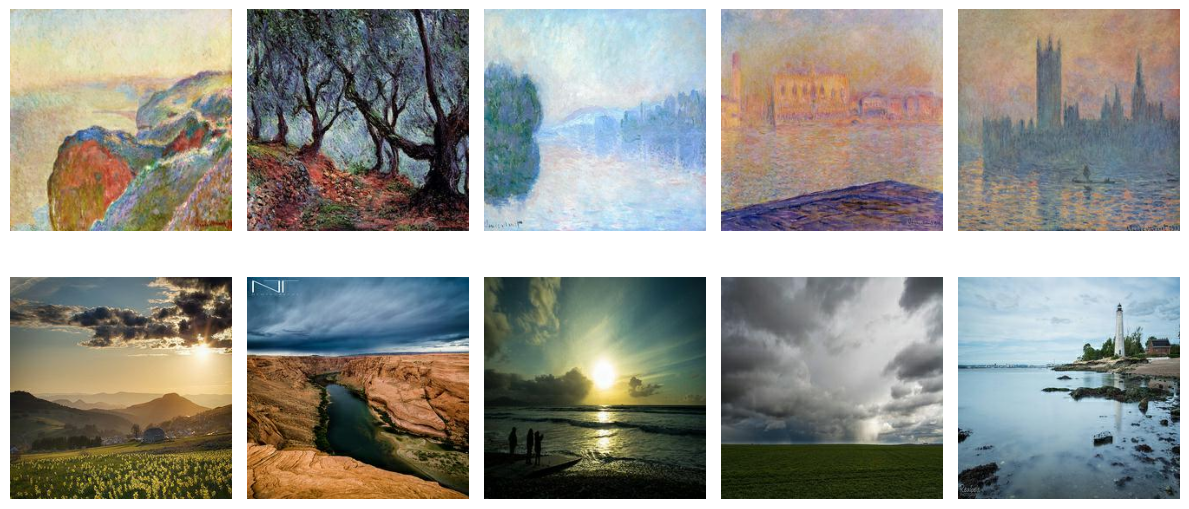

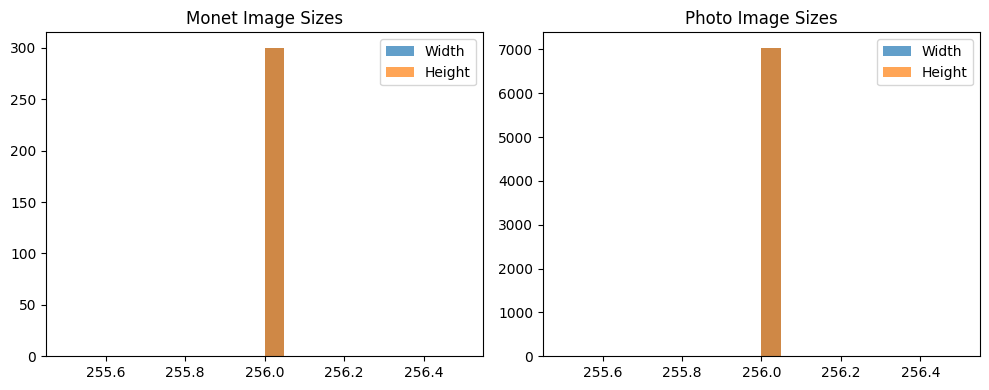

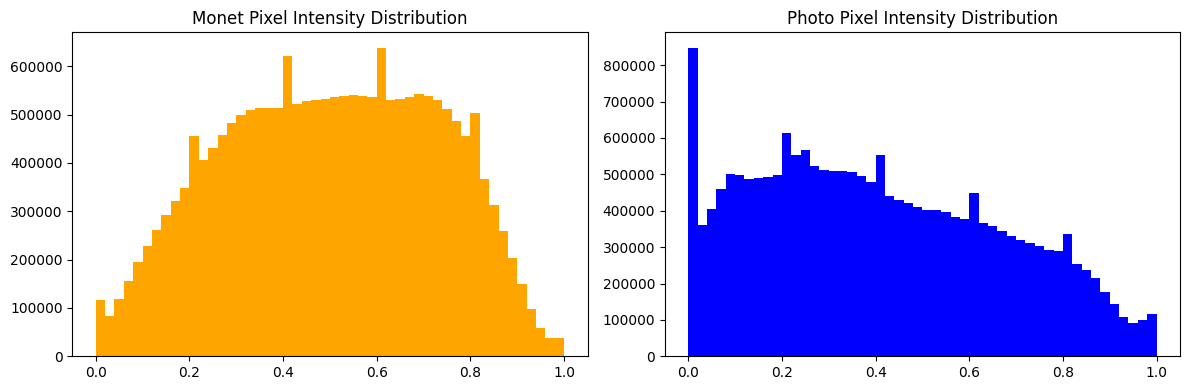

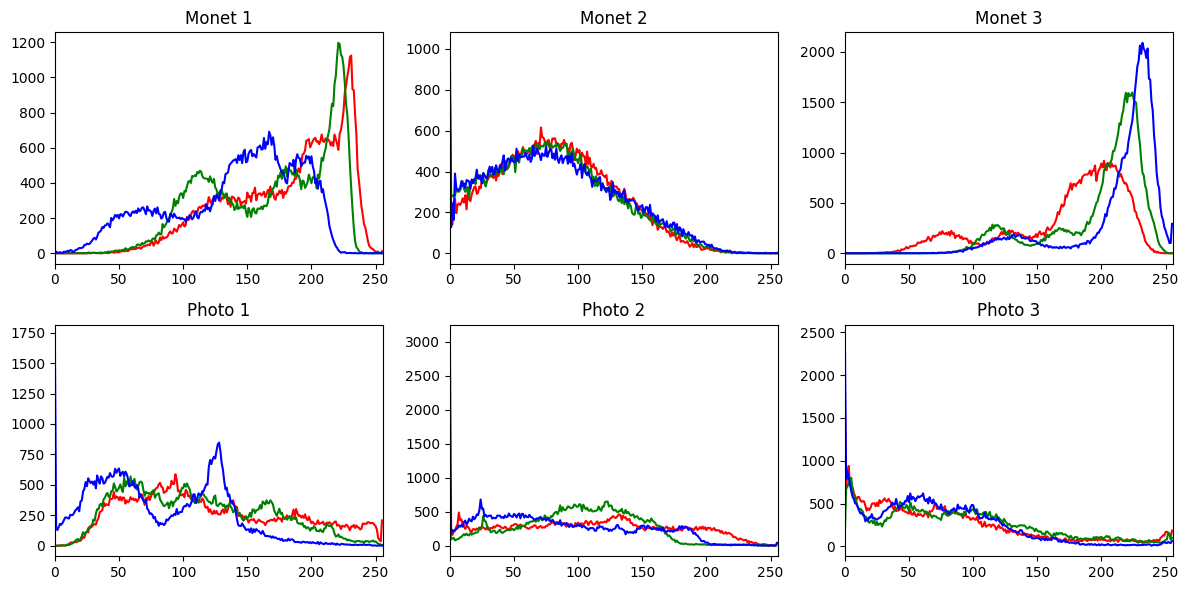

In [3]:
monet_paths = sorted(glob('/kaggle/input/gan-getting-started/monet_jpg/*.jpg'))
photo_paths = sorted(glob('/kaggle/input/gan-getting-started/photo_jpg/*.jpg'))

monet_samples = [Image.open(p) for p in monet_paths[:5]]
photo_samples = [Image.open(p) for p in photo_paths[:5]]

plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(monet_samples[i])
    plt.axis('off')
for i in range(5):
    plt.subplot(2,5,i+6)
    plt.imshow(photo_samples[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

monet_sizes = [Image.open(p).size for p in monet_paths]
photo_sizes = [Image.open(p).size for p in photo_paths]

monet_w, monet_h = zip(*monet_sizes)
photo_w, photo_h = zip(*photo_sizes)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(monet_w, bins=20, alpha=0.7, label='Width')
plt.hist(monet_h, bins=20, alpha=0.7, label='Height')
plt.title('Monet Image Sizes')
plt.legend()
plt.subplot(1,2,2)
plt.hist(photo_w, bins=20, alpha=0.7, label='Width')
plt.hist(photo_h, bins=20, alpha=0.7, label='Height')
plt.title('Photo Image Sizes')
plt.legend()
plt.tight_layout()
plt.show()

def get_pixel_stats(paths):
    stats = []
    for p in paths[:100]:
        img = np.array(Image.open(p).resize((256,256))) / 255.
        stats.append(img)
    stats = np.stack(stats)
    return stats

monet_pixels = get_pixel_stats(monet_paths)
photo_pixels = get_pixel_stats(photo_paths)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(monet_pixels.ravel(), bins=50, color='orange')
plt.title('Monet Pixel Intensity Distribution')
plt.subplot(1,2,2)
plt.hist(photo_pixels.ravel(), bins=50, color='blue')
plt.title('Photo Pixel Intensity Distribution')
plt.tight_layout()
plt.show()

def plot_rgb_histogram(img):
    img = np.array(img.resize((256,256)))
    color = ('r','g','b')
    for i,col in enumerate(color):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
    plt.xlim([0,256])

plt.figure(figsize=(12,6))
for i in range(3):
    plt.subplot(2,3,i+1)
    plot_rgb_histogram(monet_samples[i])
    plt.title(f'Monet {i+1}')
    plt.subplot(2,3,i+4)
    plot_rgb_histogram(photo_samples[i])
    plt.title(f'Photo {i+1}')
plt.tight_layout()
plt.show()


Step 3: Model Architecture

CycleGan was chosen as it works well with unpaired data, which is what the kaggle-provided data is. The cycle consistency loss it uses allows the model to apply translations, like the style translation in the project, and have it match the style of the training set. The kaggle project also recommended this architecture. 

This architecture was also chosen over other GAN architectures because of its loss function. Take for example, DCGAN. This is really good at generating images and identifying important features. However, in this case, we aren't looking to identify prominent features, but rather map between styles.

Hyperparameter configuration - a total of 8 configurations were used, with the sum of the generator and discriminator losses as the metric. Each configuration was trained, and the losses from each model used to determine the best performing set.

Learning rates: 0.0002, 0.0001

Adam optimizer beta1 values: 0.5, 0.75

Batch sizes: 1, 2

Epochs: 5


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from glob import glob
from PIL import Image

global generator_save
# Customizable Hyperparameters
def cycle_gan_model(learning_rate=0.0002,
                    beta_1=0.5,
                    batch_size=1,
                    epochs=100,
                    img_size=(256, 256)):
    # Paths to the dataset
    monet_path = '/kaggle/input/gan-getting-started/monet_jpg'
    photo_path = '/kaggle/input/gan-getting-started/photo_jpg'

    # Image preprocessing function
    def preprocess_image(image_path):
        image = Image.open(image_path).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image).astype(np.float32)
        image = (image / 127.5) - 1  # Normalize to [-1, 1]
        return image

    # Load and preprocess images
    def load_images(path):
        images = []
        for img_path in glob(os.path.join(path, '*.jpg')):
            images.append(preprocess_image(img_path))
        return np.array(images)

    # Prepare datasets
    monet_images = load_images(monet_path)
    photo_images = load_images(photo_path)

    # Create TensorFlow datasets
    monet_dataset = tf.data.Dataset.from_tensor_slices(monet_images).shuffle(300).batch(batch_size)
    photo_dataset = tf.data.Dataset.from_tensor_slices(photo_images).shuffle(300).batch(batch_size)

    # Generator Model
    def build_generator():
        input_shape = (img_size[0], img_size[1], 3)
        model = Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
        ])
        return model

    # Discriminator Model
    def build_discriminator():
        input_shape = (img_size[0], img_size[1], 3)
        model = Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, 4, padding='same')
        ])
        return model

    # Loss functions
    def cycle_loss(real_image, cycled_image, lambda_cycle=10):
        return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

    def identity_loss(real_image, same_image, lambda_identity=0.5):
        return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))

    def discriminator_loss(real, generated):
        real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real), logits=real))
        generated_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated), logits=generated))
        return real_loss + generated_loss

    def generator_loss(generated):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(generated), logits=generated))

    # Setup the models
    generator_g = build_generator()
    global generator_save
    generator_save = generator_g
    generator_f = build_generator()
    discriminator_x = build_discriminator()
    discriminator_y = build_discriminator()

    # Optimizers
    gen_g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    gen_f_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    disc_x_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    disc_y_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)

    # Training step
    @tf.function
    def train_step(real_x, real_y):
        with tf.GradientTape(persistent=True) as tape:
            fake_y = generator_g(real_x, training=True)
            fake_x = generator_f(real_y, training=True)

            cycled_x = generator_f(fake_y, training=True)
            cycled_y = generator_g(fake_x, training=True)

            same_x = generator_f(real_x, training=True)
            same_y = generator_g(real_y, training=True)

            disc_real_x = discriminator_x(real_x, training=True)
            disc_real_y = discriminator_y(real_y, training=True)

            disc_fake_x = discriminator_x(fake_x, training=True)
            disc_fake_y = discriminator_y(fake_y, training=True)

            gen_g_loss = generator_loss(disc_fake_y)
            gen_f_loss = generator_loss(disc_fake_x)

            total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

            total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
            total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

            disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

        # Apply gradients
        generator_g_grads = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
        generator_f_grads = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

        discriminator_x_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
        discriminator_y_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

        gen_g_optimizer.apply_gradients(zip(generator_g_grads, generator_g.trainable_variables))
        gen_f_optimizer.apply_gradients(zip(generator_f_grads, generator_f.trainable_variables))

        disc_x_optimizer.apply_gradients(zip(discriminator_x_grads, discriminator_x.trainable_variables))
        disc_y_optimizer.apply_gradients(zip(discriminator_y_grads, discriminator_y.trainable_variables))

        return (total_gen_g_loss + total_gen_f_loss) / 2.0, (disc_x_loss + disc_y_loss) / 2.0

    # Training loop
    def train(dataset, epochs=100):
        for epoch in range(epochs):
            total_loss = 0
            for real_x, real_y in zip(dataset[0], dataset[1]):
                gen_loss, disc_loss = train_step(real_x, real_y)
                total_loss += gen_loss
                total_loss += disc_loss
        return total_loss       
                
    
    # Prepare datasets
    dataset = (monet_dataset, photo_dataset)
    loss = train(dataset, epochs=epochs)
    return loss
    


2025-04-21 19:08:22.233026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745262502.707299      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745262502.849459      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
results = []

learning_rates = [0.0002, 0.0001]
beta_1_values = [0.5, 0.75]
batch_sizes = [1, 2]
epochs = 5

for lr in learning_rates:
    for beta in beta_1_values:
        for batch in batch_sizes:
            print(f"Running model with LR={lr}, Beta_1={beta}, Batch={batch}")
            loss = cycle_gan_model(
                learning_rate=lr,
                beta_1=beta,
                batch_size=batch,
                epochs=epochs
            )
            print(loss)
            results.append({
                'learning_rate': lr,
                'beta_1': beta,
                'batch_size': batch,
                'final_gen_loss': loss
            })

best = sorted(results, key=lambda x: x['final_gen_loss'])[0]
print("Best config:", best)

Running model with LR=0.0002, Beta_1=0.5, Batch=1


I0000 00:00:1745260103.690397     683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745260103.691091     683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1745260135.470573     723 cuda_dnn.cc:529] Loaded cuDNN version 90300


tf.Tensor(2268.3384, shape=(), dtype=float32)
Running model with LR=0.0002, Beta_1=0.5, Batch=2
tf.Tensor(1109.6647, shape=(), dtype=float32)
Running model with LR=0.0002, Beta_1=0.75, Batch=1
tf.Tensor(2349.332, shape=(), dtype=float32)
Running model with LR=0.0002, Beta_1=0.75, Batch=2
tf.Tensor(1176.0795, shape=(), dtype=float32)
Running model with LR=0.0001, Beta_1=0.5, Batch=1
tf.Tensor(2116.2854, shape=(), dtype=float32)
Running model with LR=0.0001, Beta_1=0.5, Batch=2
tf.Tensor(1019.94, shape=(), dtype=float32)
Running model with LR=0.0001, Beta_1=0.75, Batch=1
tf.Tensor(2146.0195, shape=(), dtype=float32)
Running model with LR=0.0001, Beta_1=0.75, Batch=2
tf.Tensor(1066.5447, shape=(), dtype=float32)
Best config: {'learning_rate': 0.0001, 'beta_1': 0.5, 'batch_size': 2, 'final_gen_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1019.9400024414062>}


Step 4: Results and Analysis

Based on the hyperparameter tuning, the best of the tested cases was a learning rate of 0.0001, a beta_1 value of 0.5, and a batch size of 2. In terms of reasoning for these settings, lower learning rates help to promote stability of convergence, 0.5 is on the lower side, which helps make the learning cycle between generator and discriminator faster, and batch size being 2, on the higher side, introduces more data which strengthens the result, but no so much as to cause instability or memory issues. On particular point of difficulty with the training was the batch size. Larger batch sizes were causing memory issues and very long training cycles, so to troubleshoot, those were capped at 2 for the hyperparameter optimization.

In [8]:
import pandas as pd
import seaborn as sns

# Convert to DataFrame
df = pd.DataFrame(results)

# Print results as a table
print(df.sort_values('final_gen_loss'))


   learning_rate  beta_1  batch_size  \
5         0.0001    0.50           2   
7         0.0001    0.75           2   
1         0.0002    0.50           2   
3         0.0002    0.75           2   
4         0.0001    0.50           1   
6         0.0001    0.75           1   
0         0.0002    0.50           1   
2         0.0002    0.75           1   

                                  final_gen_loss  
5    tf.Tensor(1019.94, shape=(), dtype=float32)  
7  tf.Tensor(1066.5447, shape=(), dtype=float32)  
1  tf.Tensor(1109.6647, shape=(), dtype=float32)  
3  tf.Tensor(1176.0795, shape=(), dtype=float32)  
4  tf.Tensor(2116.2854, shape=(), dtype=float32)  
6  tf.Tensor(2146.0195, shape=(), dtype=float32)  
0  tf.Tensor(2268.3384, shape=(), dtype=float32)  
2   tf.Tensor(2349.332, shape=(), dtype=float32)  


Step 5: Conclusion

The problem explored in this project was training a cycleGAN to convert images into Monet style. Based on hyperparamter tuning, the best set of parameters was a learning rate of 0.0001, a beta_1 value of 0.5, and a batch size of 2. The main takeaway from this process was that a round of this training, with only 5 epochs, even with hyperparameter tuning is not enough to create high fidelity dupes of the monet style. However, progress is made towards shifting the essence of the picture to that of a monet. This is a key takeaway - we are able to distill down the essence of something and replicate it to an extent with deep learning. Something that didn't work well in this process was training with high epoch counts or large batch sizes. This caused extremely long training times and abundant out of memory errors. However, further investigations leveraging more powerful hardware might expand the limits I imposed on these paramters to yield higher fidelity results.

In [5]:
import zipfile
import io
from glob import glob


best_model = cycle_gan_model(
    learning_rate=best['learning_rate'],
    beta_1=best['beta_1'],
    batch_size=best['batch_size'],
    epochs=5
)


def preprocess_image(path):
    image = Image.open(path).convert("RGB").resize((256, 256))
    image = np.array(image).astype(np.float32)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image
    
test_path = "/kaggle/input/gan-getting-started/photo_jpg"
test_image_paths = sorted(glob(os.path.join(test_path, "*.jpg")))
test_images = np.array([preprocess_image(p) for p in test_image_paths])
global generator_save
generated_images = []
for img in test_images:
    img = np.expand_dims(img, axis=0)
    pred = generator_save.predict(img)
    generated_images.append(pred[0])

generated_images = np.array(generated_images)


zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, "w") as zf:
    for i, img in enumerate(generated_images):
        img = ((img + 1) * 127.5).astype(np.uint8)
        img_pil = Image.fromarray(img)
        buffer = io.BytesIO()
        img_pil.save(buffer, format="JPEG")
        buffer.seek(0)
        zf.writestr(f"{i}.jpg", buffer.read())

print(f"{len(generated_images)} images written to {zip_filename}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━